# Install and import depedencies

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# Keypoints using Mediapipe Holistic

In [3]:
mp_holistic = mp.solutions.holistic     # Holistic model
mp_drwing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(img, model):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Convert the color from BGR to RGB
    image.flags.writeable = False                  # Set image to be not writeable
    result = model.process(image)                  # Make the prediction
    image.flags.writeable = True                   # Set image back to writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert the color back from RGB to BGR
    
    return image, result

In [5]:
def draw_landmarks(img, result):
    # Draw the Face connections
    mp_drwing.draw_landmarks(img, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drwing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drwing.DrawingSpec(color=(100,256,121), thickness=1, circle_radius=1))
    
    # Draw the Pose connections
    mp_drwing.draw_landmarks(img, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drwing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=3),
                             mp_drwing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=2))
    
    # Draw the Hand connections
    mp_drwing.draw_landmarks(img, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drwing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=3),
                             mp_drwing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    
    # Draw the Hand connections
    mp_drwing.draw_landmarks(img, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drwing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=3),
                             mp_drwing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Read feed
        ret, frame = cap.read()

        # Make the detection
        image, result = mediapipe_detection(frame, model=holistic)
        #print(result)
        
        #Draw Landmarks in real time
        draw_landmarks(image, result)
        
        cv2.imshow("OpenCV Feed", image)
        #Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

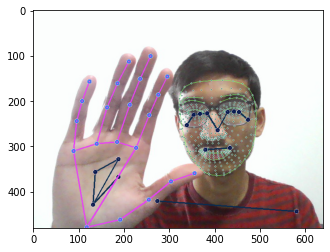

In [7]:
draw_landmarks(frame, result) #Call the draw_landmarks function and passing the frame and result
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) #Show the landmarks on the static image

# Extract Keypoints values

In [8]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)

In [9]:
# Create teh function for above keypoints that we stored
def extract_keypoints(result):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(1404)
    left_hand = np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
    
    # Concatenate all the above results
    return np.concatenate([pose, face, right_hand, left_hand], axis =0)

In [10]:
# Checking the function
result_test = extract_keypoints(result)

In [11]:
np.save('0',result_test)

# Set up folders for collection

In [12]:
# Set the path for exported data, numpy array
data_path = os.path.join('MP_Data')

# Action trying to Detect
actions = np.array(['Hello', 'Thanks', 'Iloveyou'])

# Make 30 videos worth data
no_sequence = 30

# Videos length with 30 frames
sequence_length = 30

In [13]:
# Create folders for each actions. In our case it is "Hello", "Thanks", "Iloveyou"
for action in actions:
    #within each sub folders we have 0 to 29 folders for no of sequence
    for sequence in range(no_sequence):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

# Collecting keypoints values for Training and Testing

In [14]:

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
   
    # Loop through all the actions
    for action in actions:
        # Loop through each of the video (here 3o times)
        for sequence in range(no_sequence):
            # Loop through Video length
            for frame_num in range(sequence_length):
    
    
                #Read feed
                ret, frame = cap.read()

                # Make the detection
                image, result = mediapipe_detection(frame, model=holistic)
                #print(result)

                #Draw Landmarks in real time
                draw_landmarks(image, result)
                
                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'Starting Collection', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting Frames for {} video number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow("OpenCV Feed", image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting Frames for {} video number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow("OpenCV Feed", image)
                
                # Export Keyt points
                keypoints = extract_keypoints(result)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                #Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

# Preprocess Data and create Lable and Features

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
# Create the Dictionary for the actions (Hello = 0, Thanks = 1, Iloveyou = 3)
label_map = {label:num for num, label in enumerate(actions)}

label_map

{'Hello': 0, 'Thanks': 1, 'Iloveyou': 2}

In [17]:
#sequences represents the X data and labels represents the y data. (features and labels)
sequences, labels = [], []

# Loop through each of the action (Hello, Thanks, and Iloveyou)
for action in actions:
    # Loop through each of the sequences, remember we have 30 no_sequence
    for sequence in range(no_sequence):
        window = []
        # Loop through each of the video frames (in each video 30 frames of length).
        for frame_num in range(sequence_length):
            # Load the numpy frames that we have stored
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        # Once Video1 is done
        
        # Append to the sequences array
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
# Creating Features
X = np.array(sequences)

In [19]:
# Apply the One-hot encoding
y = to_categorical(labels).astype(int)

In [20]:
# Let's apply the Train and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Build and Train LSTM Nueral Net

In [21]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [22]:
# Create the TensorBoard callback to store the Log of Model
#log_dir = os.path.join('Logs')
#tb_callback = TensorBoard(log_dir = log_dir)

In [23]:
# Create the Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662))) # X shape is (90, 30, 1662). Input layer
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) # return_sequences=False because next layer is not the LSTM
model.add(Dense(64, activation='relu')) # Dense layer
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # Output layer (action)

In [24]:
# Compile the Model
model.compile(optimizer= 'Adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [75]:
# Fit the model
model.fit(X_train, y_train, epochs= 250)

Epoch 1/250
3/3 [==============================] - 0s 103ms/step - loss: 0.2683 - categorical_accuracy: 0.9176
Epoch 2/250
3/3 [==============================] - 0s 108ms/step - loss: 0.5438 - categorical_accuracy: 0.8235
Epoch 3/250
3/3 [==============================] - 0s 97ms/step - loss: 0.3413 - categorical_accuracy: 0.8941
Epoch 4/250
3/3 [==============================] - 0s 99ms/step - loss: 0.3869 - categorical_accuracy: 0.8353
Epoch 5/250
3/3 [==============================] - 0s 102ms/step - loss: 0.2566 - categorical_accuracy: 0.9176
Epoch 6/250
3/3 [==============================] - 0s 104ms/step - loss: 0.1598 - categorical_accuracy: 0.9529
Epoch 7/250
3/3 [==============================] - 0s 98ms/step - loss: 0.1436 - categorical_accuracy: 0.9765
Epoch 8/250
3/3 [==============================] - 0s 103ms/step - loss: 0.1429 - categorical_accuracy: 0.9529
Epoch 9/250
3/3 [==============================] - 0s 104ms/step - loss: 0.1465 - categorical_accuracy: 0.9647
Epoc

KeyboardInterrupt: 

In [76]:
# Look at the Summary of the Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
__________________________________________________

# Make Predictions

In [77]:
pred = model.predict(X_test)

In [78]:
np.argmax(pred[3])

1

In [79]:
# Compare the Predictions with the test data

# Prediction
actions[np.argmax(pred[3])]

'Thanks'

In [80]:
# Test data
actions[np.argmax(y_test[3])]

'Thanks'

# Save Weights of the Model

In [81]:
model.save('Action.h5')

In [52]:
# To load the Model
#model.load_weights('Action.h5')

# Evaluation using Confusion Matrix and Accuracy

In [82]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [83]:
yhat = model.predict(X_test)

In [84]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [88]:
# Confusion Matrix
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[2, 1],
        [0, 2]],

       [[3, 0],
        [1, 1]]], dtype=int64)

In [89]:
# Check the Accuracy Score
accuracy_score(ytrue, yhat)

0.8

# Test in  Real Time

In [105]:
# 1. Create the Detection Variable
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Read feed
        ret, frame = cap.read()

        # Make the detection
        image, result = mediapipe_detection(frame, model=holistic)
        #print(result)
        
        #Draw Landmarks in real time
        draw_landmarks(image, result)
        
        # 2. Prediction Logic
        keypints = extract_keypoints(result)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            # Our model's Prediction shape is (30,1662). But, we want the shape (num_sequences (1), 30, 1662). Thus we need to
            # use np.expand_dims function.
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
            print(actions[np.argmax(res)])
        
            # Vizulization logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
        
        # Draw on the Screen
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.imshow("OpenCV Feed", image)
        #Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou
Iloveyou


1662